# Анализ лояльности пользователей Яндекс Афиши

- Автор: Нелюбин Павел Андреевич
- Дата: 11.11.2025

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install phik

In [2]:
# Импорт библиотек
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from dotenv import load_dotenv
import os

In [3]:
# Создание подключения
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

In [4]:
# Сам запрос
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name, 
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Почему это задание дублируется с 2.2? Почему две предобработки данных?

In [5]:
# Посмотрим на информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Данные представлены в количестве 290611 строк и 15 столбцов. Названия столбцов ясно выражают информацию, содержащуюся в них и соответствуют единому стилю snake_case.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [6]:
# Сначала загрузим файл с курсом валют
kurs_kzt = pd.read_csv("https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv")

# Приведём дату к правильному формату
kurs_kzt['data'] = pd.to_datetime(kurs_kzt['data'])

kurs_kzt.info()
kurs_kzt.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt


In [7]:
# Соединяем
df = df.merge(
    kurs_kzt[['data', 'curs']], 
    left_on='order_dt', 
    right_on='data', 
    how='left'
)

In [8]:
# Удалим дублирующийся столбец
df = df.drop(columns=['data'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [10]:
# Переместим курс поближе к выручке
cols = df.columns.tolist()

cols.remove('curs')

revenue_index = cols.index('revenue')

cols.insert(revenue_index + 1, 'curs')

df = df[cols]

df.head(2)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,curs,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,18.6972,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,18.3419,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион


In [11]:
# Займёмся конвертацией
df['revenue_rub'] = df['revenue'].copy()

kzt_mask = df['currency_code'] == 'kzt'

df.loc[kzt_mask, 'revenue_rub'] = df.loc[kzt_mask, 'revenue'] * (df.loc[kzt_mask, 'curs'] / 100.0)

# И поместим новый столбец после курса
cols = df.columns.tolist()

cols.remove('revenue_rub')

curs_index = cols.index('curs')
cols.insert(curs_index + 1, 'revenue_rub')

df = df[cols]

df.head(2)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,curs,revenue_rub,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,18.6972,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,18.3419,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион


In [12]:
# В проверке выше получилось посмотреть только на то, как перенеслись цены rub
# Сейчас посмотрим, как конвертировались тенге
df_kzt = df[df['currency_code'] == 'kzt']

df_kzt.head(2)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,curs,revenue_rub,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,19.0125,98.503762,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Серебрянка,Верхоречная область
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,18.9330,65.731589,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Серебрянка,Верхоречная область


Всё получилось как надо.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [13]:
# Проверим пропуски
missing = df.isnull().sum()
pct = round((missing / len(df)) * 100, 2)

result = pd.DataFrame({
    'столбец': missing.index,
    'количество пропусков': missing.values,
    'доля (%)': pct.values
})

result

,столбец,количество пропусков,доля (%)
0,user_id,0,0.00
1,device_type_canonical,0,0.00
2,order_id,0,0.00
3,order_dt,0,0.00
4,order_ts,0,0.00
5,currency_code,0,0.00
6,revenue,0,0.00
7,curs,0,0.00
8,revenue_rub,0,0.00
9,tickets_count,0,0.00


Как и сказано в задании, пропуски только в столбце `days_since_prev`, что логично, ведь пользователь мог совершить только одну покупку.

Теперь разберёмся с типами данных и размерностью:

- user_id (object) - всё нормально.
- device_type_canonical (object) - всё нормально.
- order_id (int64) - такая разрядность слишком велика, int32 должно будет хватить.
- order_dt (datetime64[ns]) - всё нормально.
- order_ts (datetime64[ns]) - всё нормально.
- currency_code (object) - буквы, всё нормально.
- revenue (float64) - можно уменьшить до float32.
- curs (float64) - можно уменьшить до float32.
- revenue_rub (float64) - можно уменьшить до float32.
- tickets_count (int64) - можно уменьшить до int8.
- days_since_prev (float64) - можно уменьшить до float32.
- event_id (int64) - int32 будет достаточно.
- event_name (object) - всё нормально.
- event_type_main (object) - всё нормально.
- service_name (object) - всё нормально.
- city_name (object) - всё нормально.
- region_name (object) - всё нормально.

Итак, займёмся оптимизацией.

In [14]:
# Проверим диапазон order_id
min_order_id = df['order_id'].min()
max_order_id = df['order_id'].max()
print(f"min: {min_order_id}, max: {max_order_id}")

min: 1, max: 8653108


In [15]:
# И поменяем тип
df['order_id'] = df['order_id'].astype('int32')

In [16]:
# Проверим диапазон revenue (есть отрицательная выручка!!)
min_rev = df['revenue'].min()
max_rev = df['revenue'].max()
print(f"min: {min_rev}, max: {max_rev}")

min: -90.76, max: 81174.54


In [17]:
# И поменяем тип
df['revenue'] = df['revenue'].astype('float32')

# И поменяем curs
df['curs'] = df['curs'].astype('float32')

# И revenue_rub
df['revenue_rub'] = df['revenue_rub'].astype('float32')

In [18]:
# Проверим диапазон tickets_count
min_tick = df['tickets_count'].min()
max_tick = df['tickets_count'].max()
print(f"min: {min_tick}, max: {max_tick}")

min: 1, max: 57


In [19]:
# И поменяем тип
df['tickets_count'] = df['tickets_count'].astype('int8')

In [20]:
# Проверим диапазон days_since_prev
min_days_since_prev = df['days_since_prev'].min()
max_days_since_prev = df['days_since_prev'].max()
print(f"min: {min_days_since_prev}, max: {max_days_since_prev}")

min: 0.0, max: 148.0


In [21]:
# И поменяем тип
df['days_since_prev'] = df['days_since_prev'].astype('float32')

In [22]:
# Проверим диапазон event_id
min_event_id = df['event_id'].min()
max_event_id = df['event_id'].max()
print(f"min: {min_event_id}, max: {max_event_id}")

min: 4436, max: 592325


In [23]:
# И поменяем тип
df['event_id'] = df['event_id'].astype('int32')

In [24]:
# Посмотрим на результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float32       
 7   curs                   290611 non-null  float32       
 8   revenue_rub            290611 non-null  float32       
 9   tickets_count          290611 non-null  int8          
 10  days_since_prev        268678 non-null  float32       
 11  event_id               290611 non-null  int32         
 12  event_name             290611 non-null  obje

Оптимизация завершена.

Приступим к поиску ошибок. Рассмотрим категориальные столбцы, в которых что-то может пойти не так:
- device_type_canonical - может быть разное написание одного и того же устройства или его отсутствие.
- event_type_main, service_name - может быть разное написание одного и того же типа события или его отсутствие.
- city_name, region_name - может быть разное написание одного и того же города или региона. Будет разумно привести к одному регистру, например, нижнему.

In [25]:
# На всякий случай проверим повторяющиеся строки
num_duplicates = df.duplicated().sum()
print(f"Найдено полных дубликатов строк: {num_duplicates}")

Найдено полных дубликатов строк: 0


In [26]:
df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

Всё в порядке.

In [27]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

Всё в порядке.

In [28]:
df['service_name'].unique()

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

Сервисов не мало, но, на глаз, неявных дубликатов или значений-заглушек не обнаружено. На всякий случай приведём к нижнему регистру.

In [29]:
df['service_name'] = df['service_name'].str.lower()

df['service_name'].unique()

array(['край билетов', 'мой билет', 'за билетом!', 'лови билет!',
       'билеты без проблем', 'облачко', 'лучшие билеты', 'прачечная',
       'быстробилет', 'дом культуры', 'весь в билетах', 'билеты в руки',
       'тебе билет!', 'show_ticket', 'городской дом культуры', 'яблоко',
       'билет по телефону', 'выступления.ру', 'росбилет',
       'шоу начинается!', 'мир касс', 'восьмёрка', 'телебилет',
       'crazy ticket!', 'реестр', 'быстрый кассир', 'карандашру',
       'радио ticket', 'дырокол', 'вперёд!', 'кино билет', 'цвет и билет',
       'зе бест!', 'тех билет', 'лимоны', 'билеты в интернете'],
      dtype=object)

In [30]:
df['city_name'] = df['city_name'].str.lower()

df['region_name'] = df['region_name'].str.lower()

In [31]:
df['city_name'].unique()

array(['глиногорск', 'озёрск', 'родниковецк', 'кристалевск',
       'дальнозолотск', 'радужнополье', 'радужсвет', 'кумсай',
       'верховино', 'светополье', 'кокжар', 'каменский', 'лесоярич',
       'никольянов', 'речинцево', 'лесозолотск', 'дальнозерск',
       'серебрянка', 'островецк', 'родниковец', 'дальнесветск',
       'луговаярово', 'ягодиновка', 'дальнополин', 'солчелуг', 'озёрчане',
       'серебровино', 'лесоярово', 'глинополье', 'глиноград',
       'дальнесветин', 'северополье', 'теплоозеро', 'горнодолинск',
       'ордакент', 'озёрово', 'луговинск', 'лугоград', 'златопольск',
       'крутовинск', 'сарыжар', 'сосновечин', 'тихоярск', 'яблонецк',
       'жаркентай', 'широковка', 'синеводов', 'синеводск', 'тихосветск',
       'радужанов', 'каменосветск', 'глиногорь', 'родниковск',
       'травогород', 'глинянск', 'радужинск', 'поляногорье',
       'дальнолесье', 'ручейник', 'ключеград', 'ключеводск', 'поленовино',
       'речичанск', 'ключевополье', 'шаныртау', 'дальнесоснов'

In [32]:
df['region_name'].unique()

array(['каменевский регион', 'североярская область', 'озернинский край',
       'лугоградская область', 'поленовский край', 'широковская область',
       'медовская область', 'златопольский округ', 'малиновоярский округ',
       'яблоневская область', 'ветренский регион', 'боровлянский край',
       'крутоводская область', 'ягодиновская область',
       'серебряноярский округ', 'лесодальний край', 'верхоречная область',
       'горицветская область', 'речиновская область', 'травиницкий округ',
       'сосновская область', 'серебринская область', 'травяная область',
       'каменноярский край', 'солнечноземская область',
       'светополянский округ', 'заречная область', 'ручейковский край',
       'глиногорская область', 'тепляковская область',
       'каменноозёрный край', 'солнечнореченская область',
       'зоринский регион', 'берёзовская область', 'лесостепной край',
       'малиновая область', 'синегорский регион', 'луговая область',
       'шанырский регион', 'каменополянский окр

Не знаю, как проверить налиичие значений-заглушек, если не вручную, но я их не вижу.

Теперь проверим числовые данные, их главные представители: `revenue_rub` и `tickets_count`.

In [33]:
print("revenue_rub:")
display(df['revenue_rub'].describe())

print("\ntickets_count:")
display(df['tickets_count'].describe())

revenue_rub:


count    290611.000000
mean        555.571960
std         875.498169
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64


tickets_count:


count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Видим в `revenue_rub` огромное максимальное значение. Также в `tickets_count` есть большой заказ на 57 билетов. Такие значения испортят всю визуализацию. Но сначала предлагаю взглянуть на эти записи.

In [34]:
df_sorted = df.sort_values('revenue_rub', ascending=False)
df_sorted.head(8)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,curs,revenue_rub,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
183754,96368e5714d1673,mobile,8067453,2024-08-24,2024-08-24 13:56:40,rub,81174.539062,19.120199,81174.539062,5,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,озёрск,североярская область
122336,5b5714894bd0517,mobile,4113477,2024-08-03,2024-08-03 22:37:17,rub,81174.539062,18.053600,81174.539062,5,3.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,озёрск,североярская область
122338,5b5714894bd0517,mobile,4113535,2024-08-03,2024-08-03 22:36:13,rub,81174.539062,18.053600,81174.539062,5,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,озёрск,североярская область
111503,5245e419c5ac876,mobile,8330309,2024-10-03,2024-10-03 13:48:03,rub,64939.628906,19.684099,64939.628906,4,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,озёрск,североярская область
198761,a6021dd115eba1e,mobile,7150734,2024-09-15,2024-09-15 20:55:15,rub,64939.628906,19.058599,64939.628906,4,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,озёрск,североярская область
122337,5b5714894bd0517,mobile,4113506,2024-08-03,2024-08-03 22:35:14,rub,64939.628906,18.053600,64939.628906,4,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,озёрск,североярская область
235142,c9d333921d46129,mobile,4299860,2024-09-12,2024-09-12 06:20:33,rub,64939.628906,19.115200,64939.628906,4,1.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,озёрск,североярская область
111934,52d3acc2caf432d,mobile,6492608,2024-09-28,2024-09-28 14:58:00,rub,64939.628906,19.374100,64939.628906,4,9.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,озёрск,североярская область


Самые крупные заказы у одного и того же сервиса, в одной и той же категории, в одном и том же городе. Если бы не зашифрованные данные, можно было бы сделать очень ценные выводы, а в таком виде это просто выбросы.

In [35]:
df_sorted = df.sort_values('tickets_count', ascending=False)
df_sorted.head(10)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,curs,revenue_rub,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
154015,7eb4fc207ecc10f,desktop,3526517,2024-08-22,2024-08-22 11:23:50,rub,0.000000,19.229099,0.000000,57,0.0,557574,05e7dbd5-b93a-4e31-9796-e9cce6741794,другое,билеты без проблем,глиногорск,каменевский регион
39416,18e9aead0a393e7,desktop,5338292,2024-09-09,2024-09-09 10:03:45,rub,640.409973,18.599100,640.409973,47,0.0,561027,a8f27570-50ca-4ff2-9550-8a5493a335a6,спорт,билеты без проблем,леснойск,чистогорская область
154591,7eb4fc207ecc10f,desktop,8151843,2024-09-17,2024-09-17 15:41:39,rub,1147.670044,19.012501,1147.670044,37,0.0,564789,f840fd65-612b-448d-8483-e12d263a013d,спорт,билеты в руки,радужсвет,медовская область
154188,7eb4fc207ecc10f,desktop,3526575,2024-08-29,2024-08-29 13:01:35,rub,0.000000,19.027599,0.000000,30,0.0,215381,2a268292-5064-413f-b080-4b1180acb8af,другое,билеты без проблем,глиногорск,каменевский регион
154187,7eb4fc207ecc10f,desktop,3526633,2024-08-29,2024-08-29 13:03:47,rub,0.000000,19.027599,0.000000,30,0.0,215381,2a268292-5064-413f-b080-4b1180acb8af,другое,билеты без проблем,глиногорск,каменевский регион
86246,3ee7dc2e115847f,desktop,5190653,2024-10-06,2024-10-06 13:06:40,rub,328.489990,19.647499,328.489990,27,0.0,575780,eaad35f5-f733-4ab1-a671-e7e86b2748c7,спорт,лови билет!,лесоярич,озернинский край
86247,3ee7dc2e115847f,desktop,5190682,2024-10-06,2024-10-06 13:08:42,rub,328.489990,19.647499,328.489990,27,0.0,575780,eaad35f5-f733-4ab1-a671-e7e86b2748c7,спорт,лови билет!,лесоярич,озернинский край
153317,7eb4fc207ecc10f,desktop,806259,2024-07-19,2024-07-19 17:06:30,rub,1926.709961,18.506701,1926.709961,19,0.0,516731,2ccf2683-25a2-4eeb-92f7-d454019a9f30,театр,мой билет,глиногорск,каменевский регион
190445,9e4f3ad398e1a2e,desktop,3091430,2024-10-15,2024-10-15 14:33:21,rub,190.059998,19.718500,190.059998,19,1.0,573817,ec43f81a-3b78-4d52-b838-bfce767be5f2,спорт,билеты без проблем,леснойск,чистогорская область
278870,f6af1139a64d911,mobile,8188499,2024-09-11,2024-09-11 19:28:17,rub,299.019989,19.025801,299.019989,19,0.0,542587,fc9cdc7f-f9be-48aa-93d9-053d46dfe72d,другое,билеты без проблем,радужанов,речицкая область


Самые крупные заказы выглядят очень странно. **Нулевые выручки**, крайне малые выручки, и практически все пользователи здесь - новые. Невозможность глубже разобраться с тем, что это были за заказы, делает эти записи бесполезными.

Итак, что мы имеем:
- в поле `revenue_rub` есть крайне высокие значения, которые будут обработаны по 99% процентилю, но в описании задания не сказано, что такое нулевые выручки, то есть не объяснена их ценность, поэтому, с моей точки зрения, они выглядят либо как возвраты, либо как выбросы (ошибки). Также присутствуют отрицательные значения, которым я никакого объяснения, кроме ошибки, не нахожу.
- в поле `tickets_count` есть заказы с большим количеством билетов, почти все они новые, большинство из них либо не имеют выручки, либо она очень мала.

In [36]:
# Посмотрим на отрицательную выручку
negative_revenue = df[df['revenue_rub'] < 0]
negative_revenue

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,curs,revenue_rub,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
252,00eb3dc9baa1543,mobile,1594653,2024-06-29,2024-06-29 15:01:43,rub,-2.37,18.419800,-2.37,3,NaN,538650,ffe03bc6-0e0c-480d-b037-6a4b55540ab5,другое,билеты без проблем,златопольск,берёзовская область
4522,02ea4583333f064,mobile,2360920,2024-09-03,2024-09-03 18:12:58,rub,-0.23,18.686800,-0.23,3,0.0,559772,592856bb-09a5-4d32-9534-0e02c6056e44,другое,билеты без проблем,лесореченск,широковская область
4549,02ea4583333f064,mobile,2361094,2024-09-04,2024-09-04 09:34:53,rub,-0.15,18.364000,-0.15,2,0.0,559772,592856bb-09a5-4d32-9534-0e02c6056e44,другое,билеты без проблем,лесореченск,широковская область
8133,043f669c9f734b1,mobile,166809,2024-09-27,2024-09-27 10:56:35,rub,-0.62,19.325600,-0.62,1,1.0,567183,9f571dad-b18a-4095-ac76-9db60d8dd97a,другое,лучшие билеты,луговинец,золотоключевской край
8134,043f669c9f734b1,mobile,166780,2024-09-27,2024-09-27 10:00:09,rub,-1.86,19.325600,-1.86,3,0.0,567183,9f571dad-b18a-4095-ac76-9db60d8dd97a,другое,лучшие билеты,луговинец,золотоключевской край
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288855,fe237d2cfd6e503,mobile,3700575,2024-10-12,2024-10-12 08:11:33,rub,-5.70,19.572300,-5.70,1,0.0,247058,a3214473-934e-44ad-a8da-82915f51583f,концерты,тебе билет!,радужанов,речицкая область
288903,fe237d2cfd6e503,desktop,3523646,2024-10-15,2024-10-15 20:32:18,rub,-1.43,19.718500,-1.43,3,0.0,243963,80f5f95b-9a58-401d-b888-4261335ae290,другое,лучшие билеты,речинцево,ягодиновская область
288904,fe237d2cfd6e503,desktop,3523617,2024-10-15,2024-10-15 20:13:13,rub,-0.96,19.718500,-0.96,2,0.0,243963,80f5f95b-9a58-401d-b888-4261335ae290,другое,лучшие билеты,речинцево,ягодиновская область
289052,fe237d2cfd6e503,mobile,5445853,2024-10-21,2024-10-21 20:22:29,rub,-0.61,19.788401,-0.61,1,0.0,243393,1f30acba-8b62-41c3-aaea-a80bf58d0d26,другое,лучшие билеты,речинцево,ягодиновская область


Значения близки к нулю, но, опять же, по моему мнению, это всё повердит дальнейшему анализу, поэтому избавимся от отрицательных значений.

In [37]:
df = df[df['revenue_rub'] >= 0].reset_index(drop=True)

print(f"Осталось строк: {len(df)}")

Осталось строк: 290230


Отфильтруем выручку по 99% процентилю.

In [38]:
p99 = df['revenue_rub'].quantile(0.99)
print(f"99-й перцентиль revenue_rub: {p99:.2f} руб.")

df = df[df['revenue_rub'] <= p99].reset_index(drop=True)

print(f"\nОсталось строк: {len(df)}")

99-й перцентиль revenue_rub: 2628.42 руб.

Осталось строк: 287405


In [39]:
print("revenue_rub:")
display(df['revenue_rub'].describe())

print("\ntickets_count:")
display(df['tickets_count'].describe())

revenue_rub:


count    287405.000000
mean        518.719299
std         511.951843
min           0.000000
25%         112.599998
50%         344.829987
75%         788.900024
max        2628.421631
Name: revenue_rub, dtype: float64


tickets_count:


count    287405.000000
mean          2.741323
std           1.163087
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

С `tickets_count`, согласно заданию, ничего делать не надо, да я и не хочу, поэтому оставим как есть.

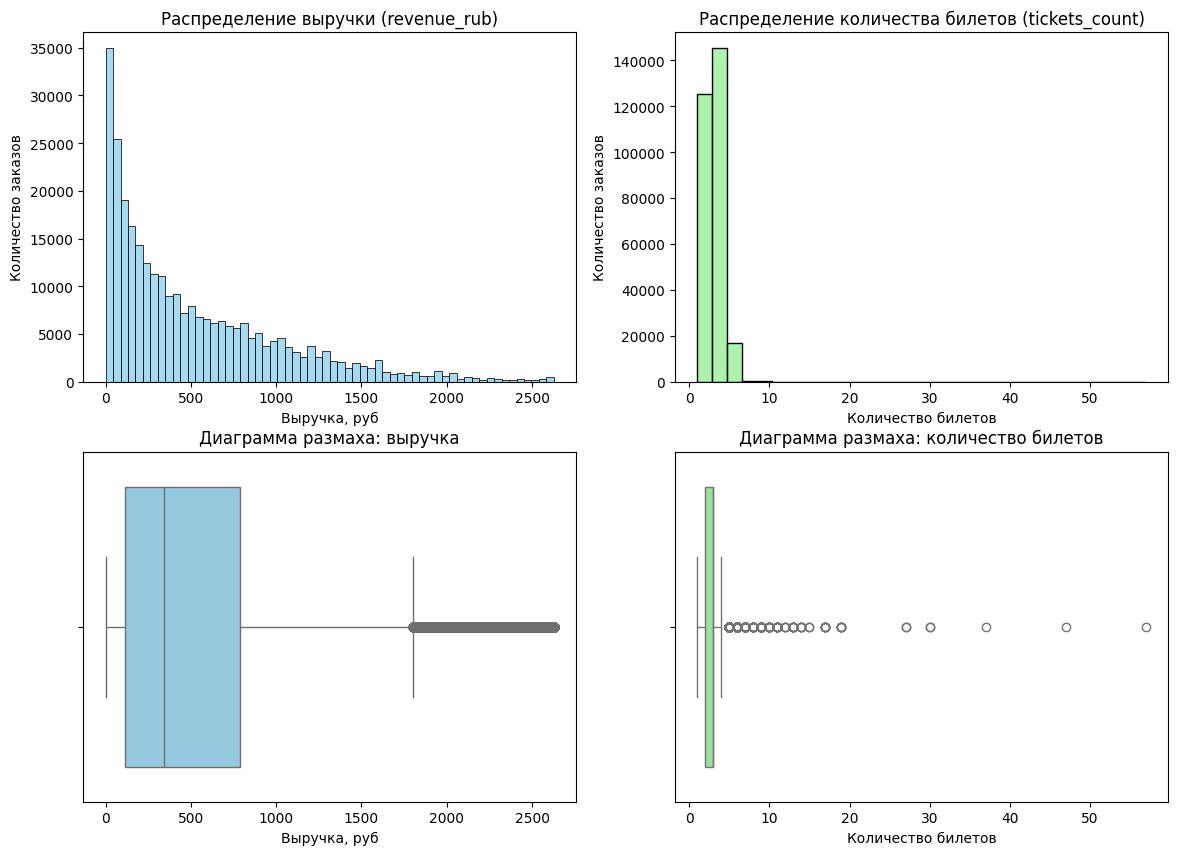

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Гистограммы
sns.histplot(df['revenue_rub'], bins=60, kde=False, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Распределение выручки (revenue_rub)')
axes[0, 0].set_xlabel('Выручка, руб')
axes[0, 0].set_ylabel('Количество заказов')

sns.histplot(df['tickets_count'], bins=30, kde=False, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Распределение количества билетов (tickets_count)')
axes[0, 1].set_xlabel('Количество билетов')
axes[0, 1].set_ylabel('Количество заказов')

# Ящики
sns.boxplot(x=df['revenue_rub'], ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Диаграмма размаха: выручка')
axes[1, 0].set_xlabel('Выручка, руб')

sns.boxplot(x=df['tickets_count'], ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Диаграмма размаха: количество билетов')
axes[1, 1].set_xlabel('Количество билетов')

plt.show()

Распределение `revenue_rub` левостороннее, с правым хвостом. На боксплоте большое количество выбрасов с правой стороны, потому что мы фильтровали значение по 99 процентилю, а Q3 + 1.5 * IQR = 1771, получается по мнению боксплота это выбросы, но по условию нет.

Визуализация `tickets_count` не наглядная из-за больших значений, с которыми неясно, что делать.

**Промежуточный вывод**

- На данном этапе изначальный датафрейм был объединён со статистикой по курсу тенге к рублю и проведена конвертация в единую валюту - рубль. Было добавлено два столбца: `curs` и `revenue_rub`.
- Оптимизирована размерность столбцов.
- Не было обнаружено явных дубликатов строк и неявных дубликатов значений в категориальных столбцах.
- Проанализированы числовые столбцы `revenue_rub` и `tickets_count`. Замечены аномально высокие значения в `revenue_rub`, которые отфильтрованы по 99 процентилю.
- Строки с отрицательным значением в `revenue_rub` удалены.
- Заказы с большими значениями `tickets_count` оставлены без изменений.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [41]:
# Отсортируем исходный датафрейм
df = df.sort_values(['user_id', 'order_ts']).reset_index(drop=True)

In [42]:
user_profile = df.groupby('user_id').agg(
    first_order_dt=('order_dt', 'first'),
    last_order_dt=('order_dt', 'last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_partner=('service_name', 'first'),
    first_event_genre=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', 'mean')  # уже содержит пропуски для первого заказа
).reset_index()

In [43]:
# Сразу сделаем размерность поменьше
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype('int8')
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype('int8')

In [44]:
print("Размер user_profile:", user_profile.shape)
user_profile.head(3)

Размер user_profile: (21838, 13)


,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_event_genre,total_orders,avg_revenue,avg_tickets,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213379,2.666667,51.0,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [45]:
#Общее число пользователей
total_users = len(user_profile)
print(f"Общее число пользователей: {total_users:,}")

# Средняя выручка с одного заказа
avg_revenue_per_order = df['revenue_rub'].mean()
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб.")

# Доля пользователей, совершивших 2 и более заказа
pct_two_plus = user_profile['is_two'].mean() * 100
print(f"Доля пользователей с 2+ заказами: {pct_two_plus:.2f}%")

# Доля пользователей, совершивших 5 и более заказа
pct_five_plus = user_profile['is_five'].mean() * 100
print(f"Доля пользователей с 5+ заказами: {pct_five_plus:.2f}%")

Общее число пользователей: 21,838
Средняя выручка с одного заказа: 518.72 руб.
Доля пользователей с 2+ заказами: 61.70%
Доля пользователей с 5+ заказами: 29.00%


In [46]:
# Общее число заказов
print("\nОбщее число заказов:")
display(user_profile['total_orders'].describe())

# Среднее число билетов в заказе
print("\nСреднее число билетов в заказе:")
display(user_profile['avg_tickets'].describe())

# Среднее количество дней между покупками
print("\nСреднее количество дней между покупками:")
display(user_profile['avg_days_between'].describe())


Общее число заказов:


count    21838.000000
mean        13.160775
std        121.577370
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: total_orders, dtype: float64


Среднее число билетов в заказе:


count    21838.000000
mean         2.744062
std          0.913083
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets, dtype: float64


Среднее количество дней между покупками:


count    13504.000000
mean        15.864348
std         22.330357
min          0.000000
25%          1.000000
50%          8.000000
75%         20.500000
max        148.000000
Name: avg_days_between, dtype: float64

Обнаружен сумасшедший любитель мероприятий с более чем десятью тысячами заказов. Предлагаю сразу дропнуть его.

In [47]:
user_profile = user_profile[user_profile['user_id'] != '0beb8fc0c0a9ce1'].reset_index(drop=True)

In [48]:
# Общее число заказов обновлённое
print("\nОбщее число заказов:")
display(user_profile['total_orders'].describe())


Общее число заказов:


count    21837.000000
mean        12.695746
std        100.294597
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       4346.000000
Name: total_orders, dtype: float64

Всё равно я решил провести фильтрацию по 99 процентилю.

In [49]:
p99_orders = user_profile['total_orders'].quantile(0.99)
print(f"99-й перцентиль числа заказов: {p99_orders:.2f}")

user_profile = user_profile[user_profile['total_orders'] <= p99_orders].reset_index(drop=True)

print(f"\nОсталось пользователей: {len(user_profile)}")
print("\nНовая статистика по total_orders:")
user_profile['total_orders'].describe()

99-й перцентиль числа заказов: 151.64

Осталось пользователей: 21618

Новая статистика по total_orders:


count    21618.000000
mean         6.469701
std         14.174562
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        151.000000
Name: total_orders, dtype: float64

Теперь уже больше похоже на правду. 

Остальные данные (среднее число билетов в заказе и среднее количество дней между покупками) выглядят достаточно реалистично.

Напоследок посмотрим на распределение пользователей по количеству заказов, но только на тех, у кого их меньше 20, так как иначе визуализация будет непонятной, а в случае такого фильтра теряется незначительная часть данных.

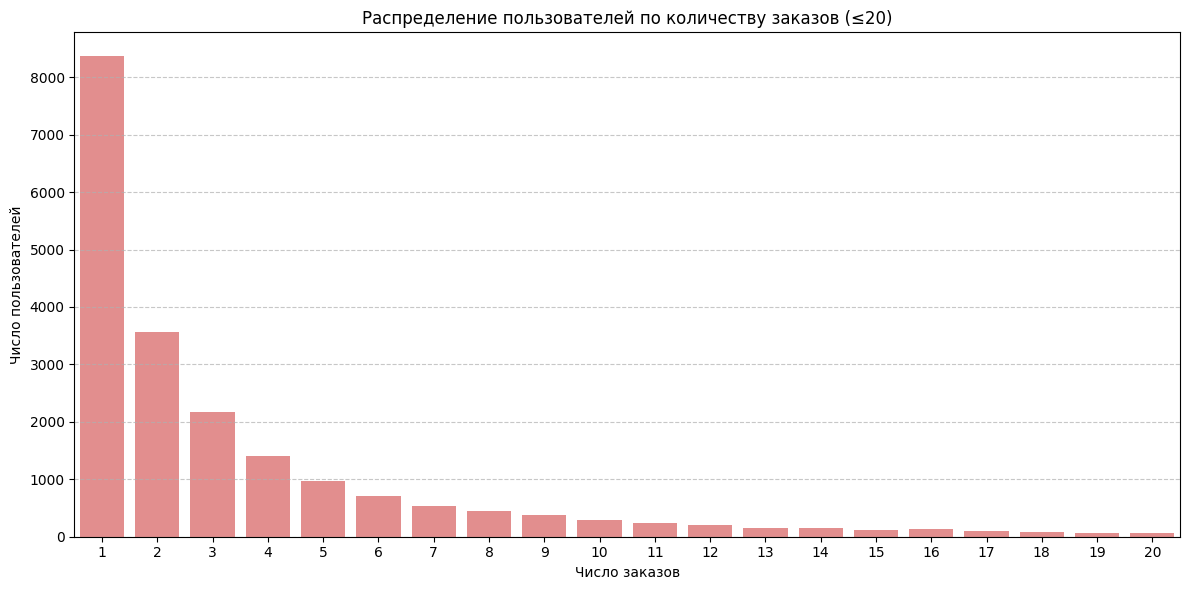

In [50]:
user_profile_subset = user_profile[user_profile['total_orders'] <= 20]
order_dist = user_profile_subset['total_orders'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=order_dist.index, y=order_dist.values, color='lightcoral')
plt.xlabel('Число заказов')
plt.ylabel('Число пользователей')
plt.title('Распределение пользователей по количеству заказов (≤20)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Как ни странно, наблюдается левостороннее распределение.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [51]:
features = ['first_event_genre', 'first_device', 'first_region', 'first_partner']

for feature in features:
    print(f"Распределение по: {feature}\n")
    
    counts = user_profile[feature].value_counts()
    total = counts.sum()
    pct = (counts / total * 100).round(2)
    
    result = pd.DataFrame({
        'Пользователей': counts,
        'Доля, %': pct
    })
    
    print(result)
    
    top_segment = counts.index[0]
    top_pct = pct.iloc[0]
    print(f"\nТочка входа: '{top_segment}' — {top_pct}% пользователей\n")

Распределение по: first_event_genre

                   Пользователей  Доля, %
first_event_genre                        
концерты                    9562    44.23
другое                      5401    24.98
театр                       4244    19.63
стендап                     1109     5.13
спорт                        794     3.67
выставки                     413     1.91
ёлки                          95     0.44

Точка входа: 'концерты' — 44.23% пользователей

Распределение по: first_device

              Пользователей  Доля, %
first_device                        
mobile                17904    82.82
desktop                3714    17.18

Точка входа: 'mobile' — 82.82% пользователей

Распределение по: first_region

                          Пользователей  Доля, %
first_region                                    
каменевский регион                 7085    32.77
североярская область               3766    17.42
широковская область                1223     5.66
озернинский край                

Пользователи распределены неравномерно, есть следующие точки входа по сегментам:
- `first_event_genre` - концерты с долей 43.91%
- `first_device` - мобильное устройство с долей 82.83%
- `first_region` - Каменевский регион с долей 32.72%
- `first_partner` - "билеты без проблем" с долей 23.88%

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [52]:
def analyze_retention_by_segment(df, segment_col):

    agg = df.groupby(segment_col).agg(
        total_users=('is_two', 'size'),
        returning_users=('is_two', 'sum')
    )
    agg['return_rate'] = (agg['returning_users'] / agg['total_users'] * 100).round(2)
    agg = agg.sort_values('total_users', ascending=False)
    
    agg_top = agg.head(10)
    
    overall_rate = (df['is_two'].mean() * 100).round(2)
    
    plt.figure(figsize=(14, 7))
    ax = sns.barplot(data=agg_top, x=agg_top.index, y='return_rate')
    
    ax.axhline(y=overall_rate, color='red', label=f'Среднее по выборке: {overall_rate}%')
    
    plt.title(f'Доля возвратившихся пользователей по сегменту: {segment_col}')
    plt.xlabel('')
    plt.ylabel('Доля пользователей с ≥2 заказами, %')
    plt.xticks(rotation=45)
    plt.legend()
 
    plt.show()
    
    print(f"\nТоп-10 сегментов по численности ({segment_col}):")
    display(agg_top[['total_users', 'return_rate']].round(2))
    
    return agg, overall_rate

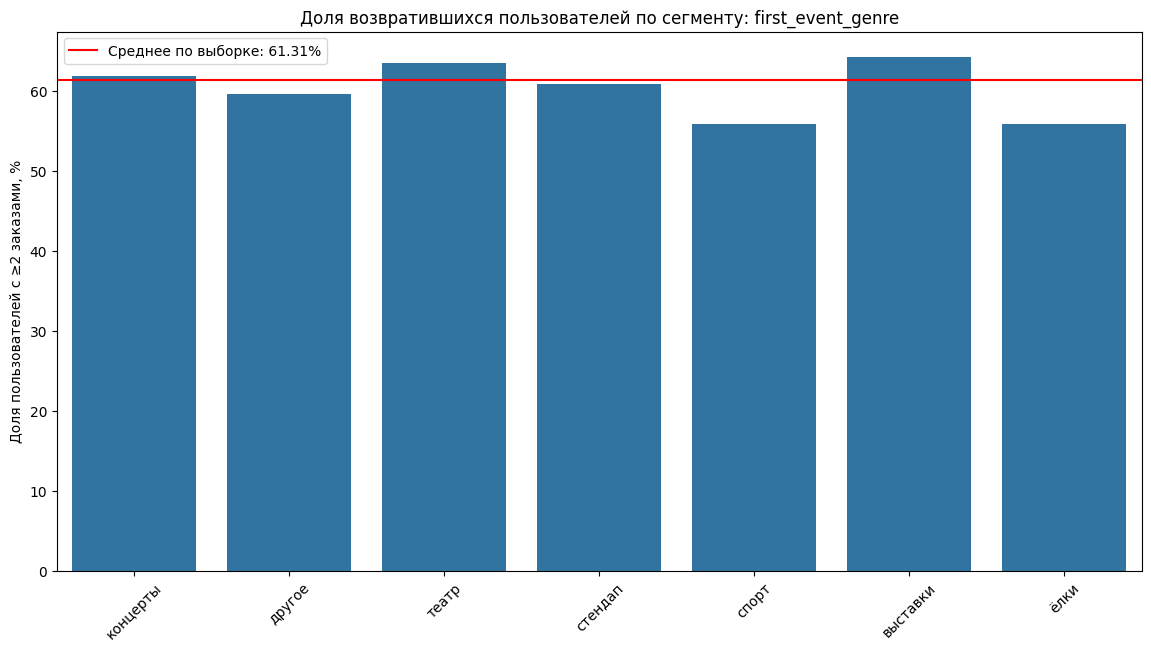


Топ-10 сегментов по численности (first_event_genre):


,total_users,return_rate
first_event_genre,,
концерты,9562,61.81
другое,5401,59.56
театр,4244,63.43
стендап,1109,60.87
спорт,794,55.79
выставки,413,64.16
ёлки,95,55.79


In [53]:
agg_genre, overall = analyze_retention_by_segment(user_profile, 'first_event_genre')

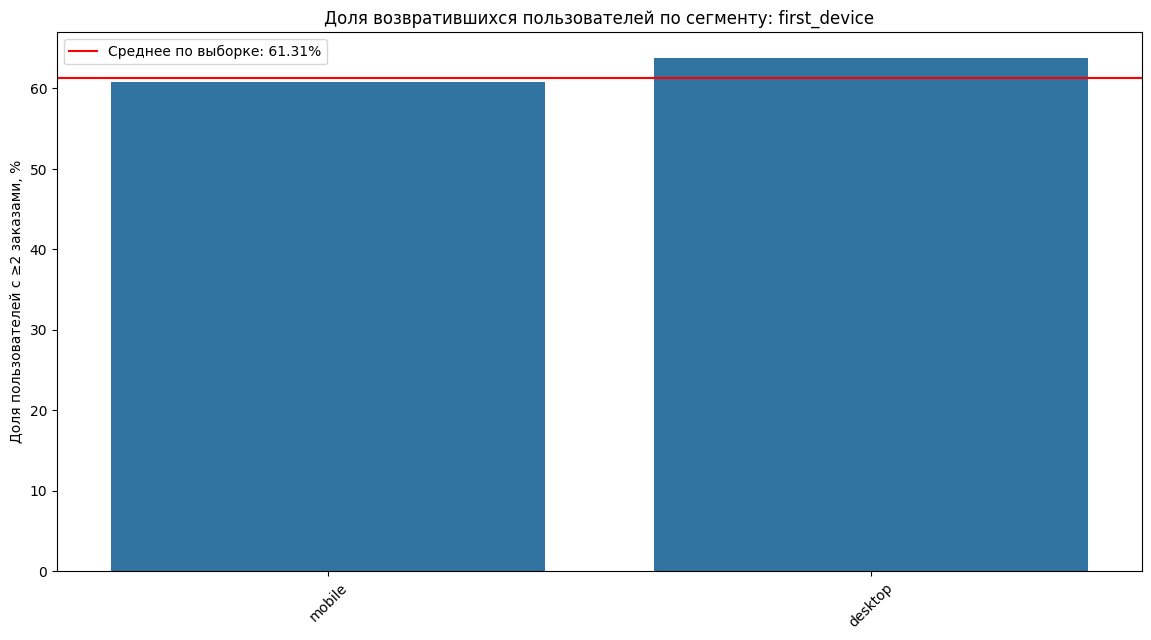


Топ-10 сегментов по численности (first_device):


,total_users,return_rate
first_device,,
mobile,17904,60.80
desktop,3714,63.81


In [54]:
agg_device, _ = analyze_retention_by_segment(user_profile, 'first_device')

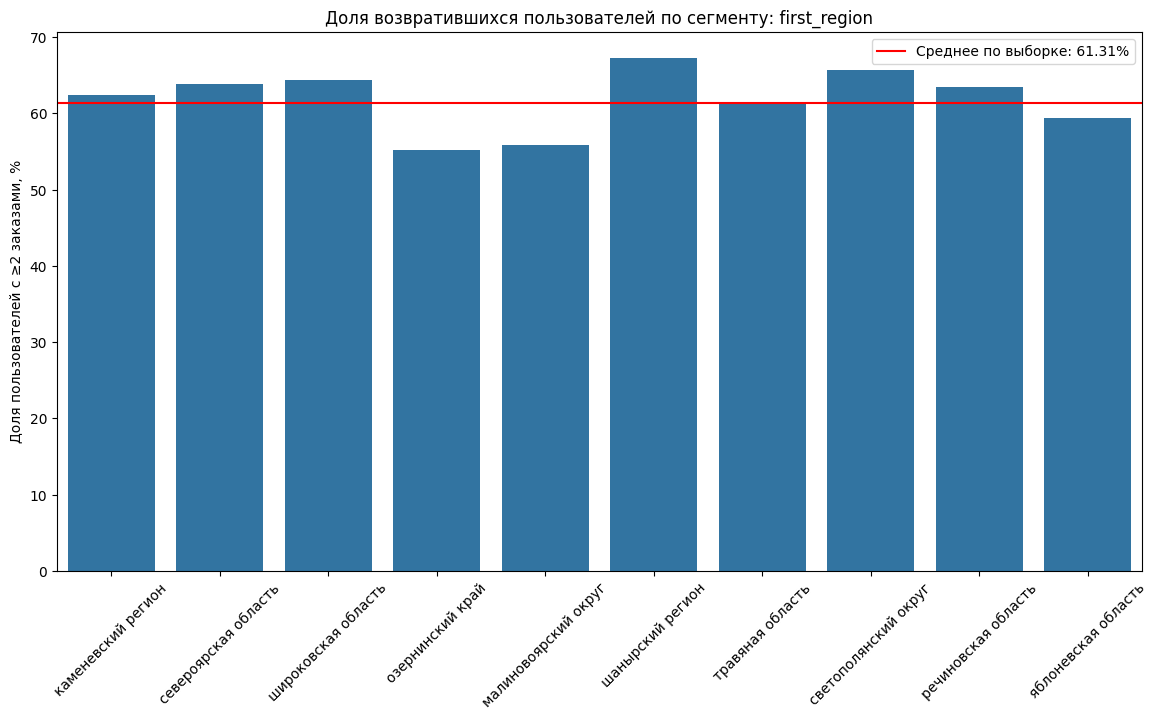


Топ-10 сегментов по численности (first_region):


,total_users,return_rate
first_region,,
каменевский регион,7085,62.39
североярская область,3766,63.81
широковская область,1223,64.43
озернинский край,675,55.26
малиновоярский округ,526,55.89
шанырский регион,502,67.33
травяная область,488,61.48
светополянский округ,457,65.65
речиновская область,440,63.41


In [55]:
agg_region, _ = analyze_retention_by_segment(user_profile, 'first_region')

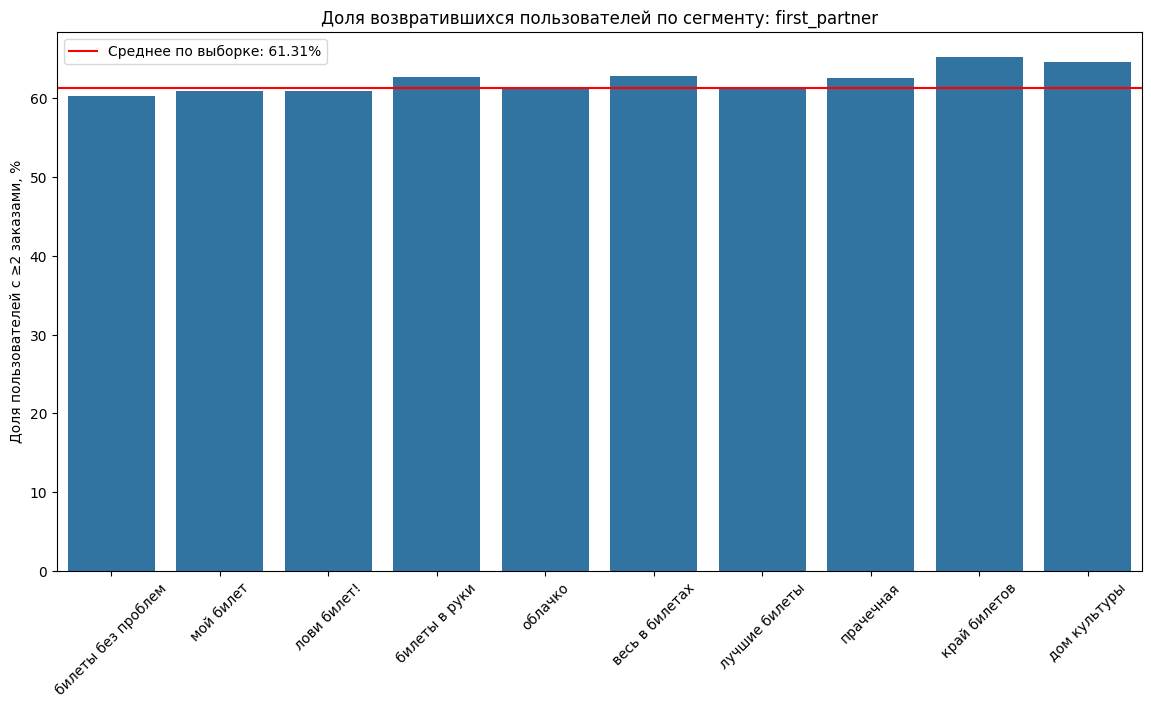


Топ-10 сегментов по численности (first_partner):


,total_users,return_rate
first_partner,,
билеты без проблем,5165,60.31
мой билет,2970,60.88
лови билет!,2812,60.95
билеты в руки,2556,62.75
облачко,2177,61.23
весь в билетах,1286,62.91
лучшие билеты,1182,61.34
прачечная,582,62.54
край билетов,454,65.20


In [56]:
agg_partner, _ = analyze_retention_by_segment(user_profile, 'first_partner')

Выделяющихся значимых точек входа не наблюдается.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1** неверна, так как доля пользователей, совершивших повторных заказ после спортивного мерояприятия (55.51%) меньше, чем доля тех, кто совершил повторный заказ после концерта (61.6%).

**Гипотеза 2** частично верна, так как в топ-3 регионах действительно высокая доля повторных заказов, а в следующих двух регионах заметно меньше, однако у ещё менее популярных регионов ниже высокий рейтинг повторных заказов.

Таким образом, гипотезу можно назвать верной для топ-5 регионов.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


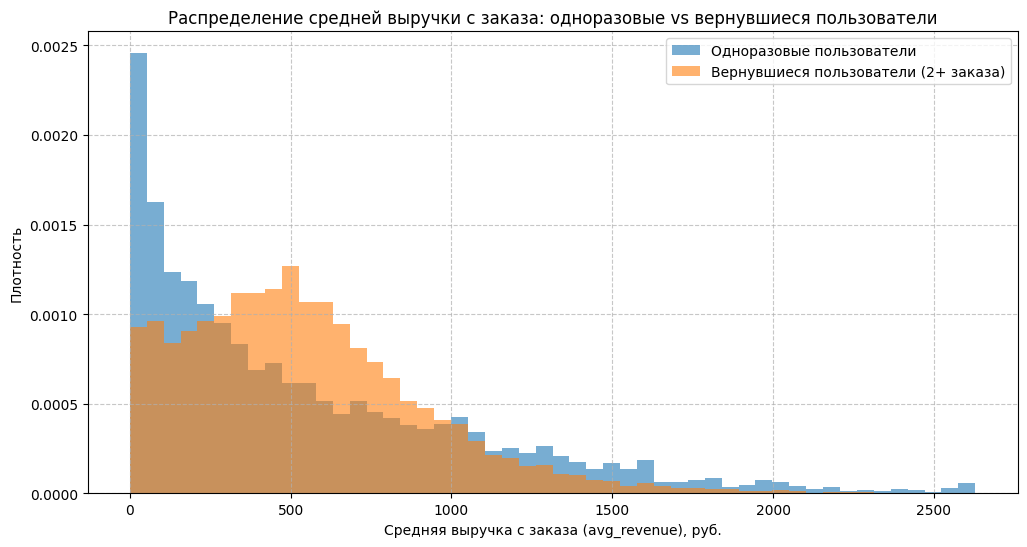

In [57]:
one_time = user_profile[user_profile['is_two'] == 0]['avg_revenue']
returning = user_profile[user_profile['is_two'] == 1]['avg_revenue']

plt.figure(figsize=(12, 6))

bins = 50

plt.hist(one_time, bins=bins, alpha=0.6, label='Одноразовые пользователи', density=True)
plt.hist(returning, bins=bins, alpha=0.6, label='Вернувшиеся пользователи (2+ заказа)', density=True)

plt.xlabel('Средняя выручка с заказа (avg_revenue), руб.')
plt.ylabel('Плотность')
plt.title('Распределение средней выручки с заказа: одноразовые vs вернувшиеся пользователи')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Между группами пользователей есть различия и очень заметные:
- одноразовые пользователи имеют очень много мелких заказов (ярко выраженный длинный правый хвост). Их основной диапазон цен от 400 рублей и менее. Присутствует огромное количество "нулевых" заказов (возвратов?);
- вернувшиеся пользователи имеют более равномерное распределение средней выручки. Их основной диапазон цен примерно от 0 до 750 рублей.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


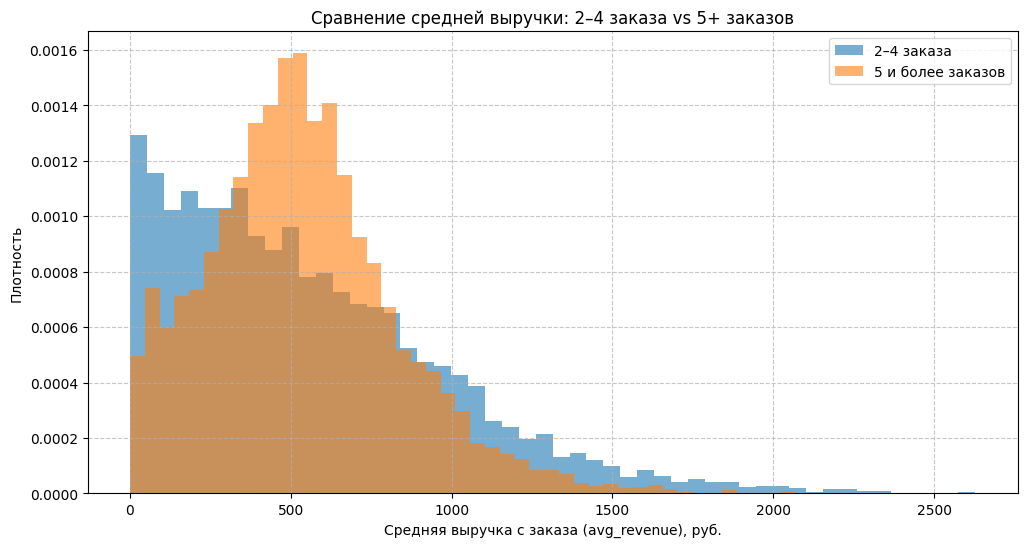

In [58]:
group_2_4 = user_profile[(user_profile['is_two'] == 1) & (user_profile['is_five'] == 0)]['avg_revenue']
group_5_plus = user_profile[user_profile['is_five'] == 1]['avg_revenue']

bins = 50

plt.figure(figsize=(12, 6))

plt.hist(group_2_4, bins=bins, alpha=0.6, label='2–4 заказа', density=True)
plt.hist(group_5_plus, bins=bins, alpha=0.6, label='5 и более заказов', density=True)

plt.xlabel('Средняя выручка с заказа (avg_revenue), руб.')
plt.ylabel('Плотность')
plt.title('Сравнение средней выручки: 2–4 заказа vs 5+ заказов')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Различия есть.

У группы с 2-4 заказами распределение левостороннее с выраженным правым хвостом.

У группы с 5+ заказами распределение напоминает нормальное с центром в значении средней выручки около 500 рублей.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

Распределение пользователей по среднему числу билетов в заказе:
ticket_segment  total_users  return_rate_%
    1–2 билета         2410          51.24
    2–3 билета         9483          73.55
   3–5 билетов         9064          54.29
    5+ билетов          661          18.76


C:\Users\xalit\AppData\Local\Temp\ipykernel_35348\2653660192.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = user_profile.groupby('ticket_segment').agg(


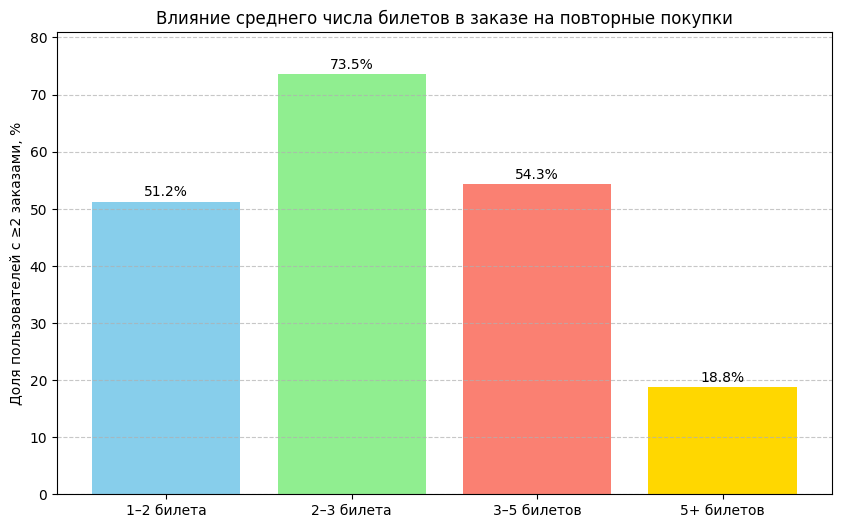

In [59]:
bins = [1, 2, 3, 5, 100]
labels = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']

user_profile['ticket_segment'] = pd.cut(
    user_profile['avg_tickets'],
    bins=bins,
    labels=labels,
    right=False 
)

segment_stats = user_profile.groupby('ticket_segment').agg(
    total_users=('user_id', 'size'),
    returning_users=('is_two', 'sum')
).reset_index()

segment_stats['return_rate_%'] = (segment_stats['returning_users'] / segment_stats['total_users'] * 100).round(2)

print("Распределение пользователей по среднему числу билетов в заказе:")
print(segment_stats[['ticket_segment', 'total_users', 'return_rate_%']].to_string(index=False))

plt.figure(figsize=(10, 6))
bars = plt.bar(
    segment_stats['ticket_segment'],
    segment_stats['return_rate_%'],
    color=['skyblue', 'lightgreen', 'salmon', 'gold']
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')

plt.ylabel('Доля пользователей с ≥2 заказами, %')
plt.title('Влияние среднего числа билетов в заказе на повторные покупки')
plt.ylim(0, max(segment_stats['return_rate_%']) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Распределение не равномерное, так как большинство пользователей сконцентрировано в сегментах 2-3 билета (9483) и 3-5 билетов (9064).

Аномально высокая доля у сегмента 2-3 билета, что является сильной точкой входа.

Аномально низкая доля у сегмента 5+ билетов.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


Поведение пользователей по дню первой покупки:
first_order_dow_name  total_users  return_rate_%
         Понедельник         2917          62.98
             Вторник         3174          61.88
               Среда         3061          62.27
             Четверг         3112          59.45
             Пятница         3256          59.77
             Суббота         3321          62.75
         Воскресенье         2777          60.06


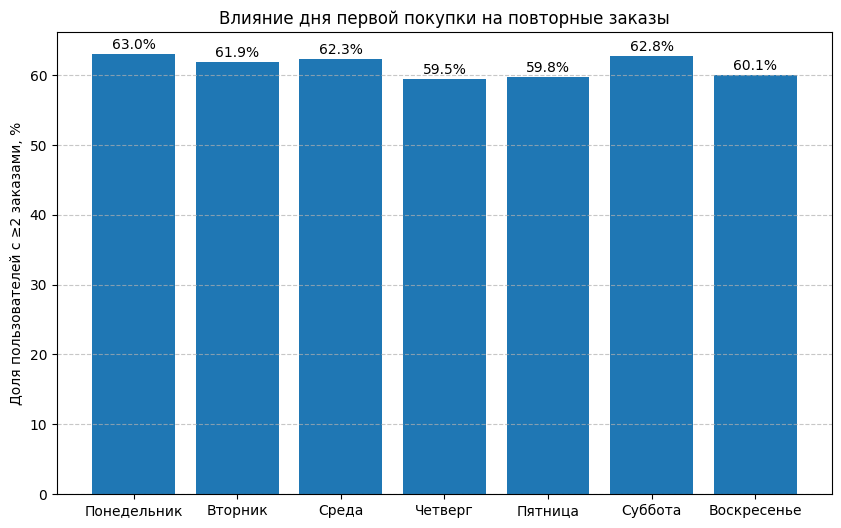

In [60]:
user_profile['first_order_dow'] = pd.to_datetime(user_profile['first_order_dt']).dt.dayofweek

dow_names = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}
user_profile['first_order_dow_name'] = user_profile['first_order_dow'].map(dow_names)

dow_stats = user_profile.groupby('first_order_dow_name').agg(
    total_users=('user_id', 'size'),
    returning_users=('is_two', 'sum')
).reset_index()

dow_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
dow_stats['first_order_dow_name'] = pd.Categorical(dow_stats['first_order_dow_name'], categories=dow_order, ordered=True)
dow_stats = dow_stats.sort_values('first_order_dow_name')

dow_stats['return_rate_%'] = (dow_stats['returning_users'] / dow_stats['total_users'] * 100).round(2)

print("Поведение пользователей по дню первой покупки:")
print(dow_stats[['first_order_dow_name', 'total_users', 'return_rate_%']].to_string(index=False))

plt.figure(figsize=(10, 6))
bars = plt.bar(
    dow_stats['first_order_dow_name'],
    dow_stats['return_rate_%']
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{height:.1f}%', ha='center', va='bottom')

plt.ylabel('Доля пользователей с ≥2 заказами, %')
plt.title('Влияние дня первой покупки на повторные заказы')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

День недели практически не влияет на вероятность повторного заказа.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [61]:
repeat_users = user_profile[user_profile['total_orders'] >= 2].copy()

group_2_4 = repeat_users[(repeat_users['total_orders'] >= 2) & (repeat_users['total_orders'] <= 4)]
group_5_plus = repeat_users[repeat_users['total_orders'] >= 5]

avg_interval_2_4 = group_2_4['avg_days_between'].mean()
avg_interval_5_plus = group_5_plus['avg_days_between'].mean()

median_interval_2_4 = group_2_4['avg_days_between'].median()
median_interval_5_plus = group_5_plus['avg_days_between'].median()

n_2_4 = len(group_2_4)
n_5_plus = len(group_5_plus)

print("Сравнение среднего интервала между заказами:")
print("\nГруппа 2–4 заказа:")
print(f"Число пользователей: {n_2_4}")
print(f"Средний интервал:    {avg_interval_2_4:.2f} дней")
print(f"Медианный интервал:  {median_interval_2_4:.2f} дней")

print("\nГруппа 5+ заказов:")
print(f"Число пользователей: {n_5_plus}")
print(f"Средний интервал:    {avg_interval_5_plus:.2f} дней")
print(f"Медианный интервал:  {median_interval_5_plus:.2f} дней")

Сравнение среднего интервала между заказами:

Группа 2–4 заказа:
Число пользователей: 7143
Средний интервал:    21.35 дней
Медианный интервал:  9.00 дней

Группа 5+ заказов:
Число пользователей: 6112
Средний интервал:    9.91 дней
Медианный интервал:  8.13 дней


Пользователи с 5-ю и более заказами возвращаются к услугам сервиса чаще, что может побуждать сервис предлагать пользователям, у которых меньше 5 заказов более выгодные условия, скидки, промокоды и так далее, чтобы побыстрее перевести их в группу 5+ заказов.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [62]:
features = [
    'first_event_genre',
    'first_device',
    'first_region',
    'first_partner',
    'avg_revenue',
    'avg_tickets',
    'avg_days_between',
    'total_orders'
]

df_corr = user_profile[features].copy()

interval_cols = ['avg_revenue', 'avg_tickets', 'avg_days_between', 'total_orders']

phik_corr = df_corr.phik_matrix(interval_cols=interval_cols)

print("Корреляция признаков с total_orders:")
phik_with_target = phik_corr['total_orders'].sort_values(ascending=False)
print(phik_with_target)

Корреляция признаков с total_orders:
total_orders         1.000000
avg_days_between     0.296380
avg_tickets          0.230192
avg_revenue          0.222279
first_region         0.124282
first_partner        0.036296
first_event_genre    0.029479
first_device         0.025653
Name: total_orders, dtype: float64


Значения корреляции приемлемые для визуализации и анализа, что-либо исправлять не нужно.

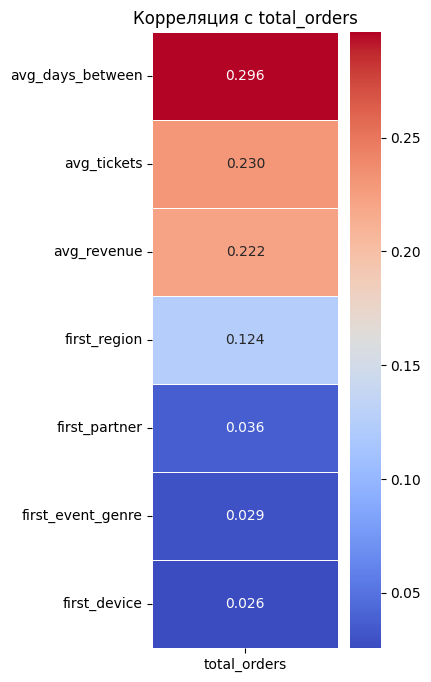

In [63]:
plt.figure(figsize=(3, 8))
data_heatmap = phik_corr.loc[phik_corr.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)
sns.heatmap(
    data_heatmap,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Корреляция с total_orders')

plt.show()

Наиболее тесно с количеством заказов связаны:
- `avg_days_between` - среднее количество дней между заказами;
- `avg_tickets` - среднее количество билетов;
- `avg_revenue` - средняя выручка.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

- Информация о данных:
    - Данные представляют собой информацию о пользователях и их заказах в сервисе Яндекс Афиша, включая дату, город, регион, тип устройства, билетного оператора и так далее. Пропуски присутствуют только в столбце с количеством прошедших дней с предыдущего заказа пользователя, что совершенно нормально, ведь пользователь может быть новым.
    - Выручка в исходном датасете представлена в двух валютах: kzt и rub. Был создан новый столбец, содержащий информацию в выручке только в рублях. Для конвертации тенге в рубли использовался датасет с ежедневным курсом за 2024 год.
    - Столбцы "город" и "регион" приведены к нижнему регистру.
    - Явных дубликатов строк не обнаружено.
    - Неявных дубликатов категориальных столбцов не обнаружено.
    - Преобразованы и оптимизированы типы данных некоторых столбцов.
    - Проанализированы числовые столбцы, в результате чего были обнаружены аномально большие значения в столбце выручки, что привело к решению о фильтрации значений по 99 процентилю. Также в этом столбце замечено большое количество нулевых значений, вероятно, возвратов, и отрицательных значений, которые были удалены, чтобы не искажать дальнейшую аналитику и визуализацию. В информации о количестве билетов в заказе тоже есть выделяющиеся большие значения, но их было решено оставить, что негативно повлияло на наглядность визуализации.
---
Для дальнейшего анализа был создан новый датафрейм, который включал в себя информацию о каждом пользователе (профиль пользователя).

---
- Основные результаты анализа:
    - Выборка включает в себя 21838 пользователей. В ней было обнаружено несколько выбросов в столбце `общее число заказов`, данные были отфильтрованы по 99 процентилю этого столбца.
    - Распределение пользователей по числу заказов неравномерное, левостороннее, с правым хвостом.
    - Вероятность повторного заказа пользователя однозначно не связана ни с какой характеристикой первого заказа.
    - У повторных пользователей средняя выручка заметно выше, чем у одноразовых.
    - Практически все пользователи попадают в сегменты "2-3 билета" и "3-5 билетов". Таким образом, пользователь, заказавший 2-3 билета совершит повторный заказ с вероятностью 73,5%, а пользователь с 3-5 билетами в заказе, вернётся с вероятностью 54,3%
    - Стоит отметить, что у крупных заказов (5+ билетов) аномально низкая доля повторных заказов (18,8%).
    - День недели не влияет на вероятность повторного заказа.
    - Медианный интервал между покупками у группы пользователей с 5 и более заказами составляет 8 дней, что на 1 день меньше, чем у группы пользователей с 2-4 заказами.
    - По корреляционному анализу числа заказов пользователя можно сделать следующие выводы о том, что влияет на увеличение их количества: уменьшение среднего интервала между заказами (возможно, бесполезный вывод, так как логичный, больше заказов = меньше интервал), увеличение количества билетов в заказе, общая стоимость заказа.
---
Одним из важнейших действий должно стать мотивирование пользователя совершать заказы с 2-мя билетами и более, так как именно такие сегменты чаще всего совершают повторные заказы. Это можно устроить различными бонусами, скидками за количество и тому подобное.


Также стоит обратить внимание на нулевые заказы (если это возвраты, то их почему-то очень много), отрицательные заказы и аномально большие и дорогие заказы.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

In [1]:
# Я requirements так сделал, надеюсь можно)
pip freeze > requirements.txt

SyntaxError: invalid syntax (2692168119.py, line 2)

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/PavelYPGH/second-project